In [1]:
import os
import numpy as np
from astropy.table import Table
from astropy.io import fits

import healpy as hp
import fitsio
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

from vast.voidfinder.postprocessing import open_fits_file


In [2]:
import sys
sys.path.insert(1, '/global/homes/h/hrincon/python_tools')

In [3]:
import VoidSlicePlots as vsp
import VoidCatalog as vc
import VoidOverlap as vo

<frozen importlib._bootstrap>:241: RuntimeWarning: vast.voidfinder._voidfinder_cython_find_next.SpatialMap size changed, may indicate binary incompatibility. Expected 1848 from C header, got 2272 from PyObject


This notebook is used to generate sliceplots of the VoidFinder catalog

In [4]:
iron_ngc_path = f'../galaxy_catalog/iron_smoothed_ngc.fits'
nsa_path= f'../galaxy_catalog/SDSS_galaxies/nsa_k1.fits'

#DESI
#------
#VoidFinder
voids_ngc_path = f'../voids/data/minus20.0/DESIVAST_NGC_VoidFinder_Output.fits'

vfc_desi = vc.VoidFinderCatalog(voids_ngc_path)
vfc_desi.add_galaxies(iron_ngc_path)  

#VIDE
voids_ngc_path = f'../voids/data/minus20.0/DESIVAST_NGC_V2_VIDE_Output.fits'

v2v_desi = vc.V2Catalog(voids_ngc_path)
v2v_desi.add_galaxies(iron_ngc_path)  

#REVOLVER
voids_ngc_path = f'../voids/data/minus20.0/DESIVAST_NGC_V2_REVOLVER_Output.fits'

v2r_desi = vc.V2Catalog(voids_ngc_path)
v2r_desi.add_galaxies(iron_ngc_path)  

#SDSS
#------
#VoidFinder
voids_ngc_path = f'../voids/data/minus20.0/SDSSK1_VoidFinder_Output.fits'

vfc_sdss = vc.VoidFinderCatalog(voids_ngc_path)
vfc_sdss.add_galaxies(nsa_path)  

#VIDE
voids_ngc_path = f'../voids/data/minus20.0/SDSSK1_V2_VIDE_Output.fits'

v2v_sdss = vc.V2Catalog(voids_ngc_path)
v2v_sdss.add_galaxies(nsa_path)  

#REVOLVER
voids_ngc_path = f'../voids/data/minus20.0/SDSSK1_V2_REVOLVER_Output.fits'

v2r_sdss = vc.V2Catalog(voids_ngc_path)
v2r_sdss.add_galaxies(nsa_path)  

In [5]:
from vast.voidfinder.distance import z_to_comoving_dist
from vast.voidfinder.voidfinder_functions import xyz_to_radecz
from vast.voidfinder.voidfinder import ra_dec_to_xyz
from vast.voidfinder._voidfinder_cython_find_next import MaskChecker

In [6]:
import pickle

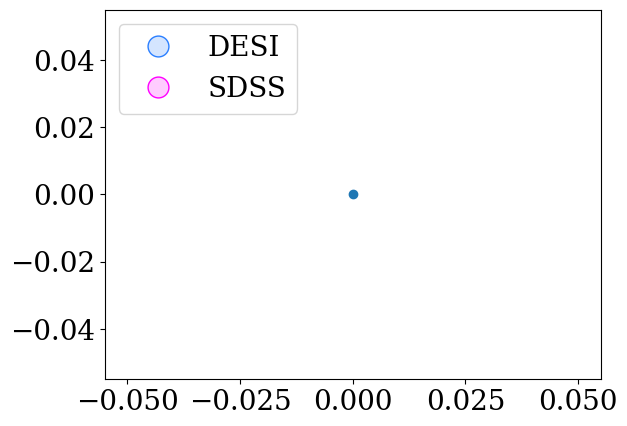

In [7]:
from matplotlib import colors as clr
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })


void_legend_handles=[]
alpha=0.2


#blue 
legend_color=clr.to_rgba('#2a7fff')
legend_color = (legend_color[0],legend_color[1],legend_color[2],alpha)
void_legend_handles.append(
    Line2D([0], [0], label='DESI', marker='o', markersize=15, 
        markeredgecolor='#2a7fff', markerfacecolor=legend_color, linestyle=''
    )
)

#pink 
legend_color=clr.to_rgba('#ff00ff')
legend_color = (legend_color[0],legend_color[1],legend_color[2],alpha)
void_legend_handles.append(
    Line2D([0], [0], label='SDSS', marker='o', markersize=15, 
        markeredgecolor='#ff00ff', markerfacecolor=legend_color, linestyle=''
    )
)

plt.scatter([0],[0])
plt.legend(handles=void_legend_handles, loc="upper left")

plt.savefig("compare_legend.png", bbox_inches = "tight", dpi=400)


In [7]:
masks_path = f'../galaxy_catalog/mask/alt_masks/masks.fits'

masks = fits.open(masks_path)

In [8]:
overlap_mask = masks['COMP'].data
mask_resolution = masks['COMP'].header['MSKRES']
dist_limits = [0, 332.38626] # SDSS distance limtis

In [9]:

def select_mask(gals, mask, mask_resolution, rmin, rmax, edge_buffer):
    mask_checker = MaskChecker(0,
                            mask.astype(bool),
                            mask_resolution,
                            rmin,
                            rmax)
    
    points_boolean = np.ones(len(gals), dtype = bool)
    
    #Flag points that fall outside the mask
    for i in range(len(gals)):
        # Declare if point is not in mask
        is_edge = vo.is_edge_point(gals['x'][i], gals['y'][i], gals['z'][i],
                                   mask, mask_resolution, rmin, rmax, edge_buffer = edge_buffer)
        # Invert not_in_mask to tag points in the mask
        points_boolean[i] = not is_edge
        
    return gals[points_boolean]

In [10]:
desi_voids_30=select_mask(vfc_desi.maximals, overlap_mask, mask_resolution, 0, 332.38626, 30)
desi_voids_10=select_mask(vfc_desi.maximals, overlap_mask, mask_resolution, 0, 332.38626, 10)
desi_voids_5=select_mask(vfc_desi.maximals, overlap_mask, mask_resolution, 0, 332.38626, 5)
sdss_voids_30=select_mask(vfc_sdss.maximals, overlap_mask, mask_resolution, 0, 332.38626, 30)
sdss_voids_10=select_mask(vfc_sdss.maximals, overlap_mask, mask_resolution, 0, 332.38626, 10)
sdss_voids_5=select_mask(vfc_sdss.maximals, overlap_mask, mask_resolution, 0, 332.38626, 5)


In [11]:
len(vfc_sdss.maximals), len(sdss_voids_5), len(sdss_voids_10), len(sdss_voids_30)

(1187, 138, 75, 1)

In [12]:
(np.sum(vfc_sdss.maximals['edge'])/len(vfc_sdss.maximals), 
 np.sum(sdss_voids_5['edge'])/len(sdss_voids_5), 
 np.sum(sdss_voids_10['edge'])/len(sdss_voids_10), 
 np.sum(sdss_voids_30['edge'])/len(sdss_voids_30)
)

(0.33361415332771693, 0.6884057971014492, 0.68, 0.0)

In [13]:
len(vfc_desi.maximals), len(desi_voids_5), len(desi_voids_10), len(desi_voids_30)

(3241, 158, 70, 1)

In [16]:
# ra dec redshift rabsmag rabsmag_inv gabsmag gabsmag_inv zabsmag zabsmag_inv ngc
iron_gals = Table.read("../galaxy_catalog/iron_ngc.fits")


In [17]:
nsa_gals=Table.read('/global/homes/h/hrincon/sdss_compare/voidfinding/nsa_v1_0_1_main_NSAID.txt',format='ascii.commented_header')

In [18]:
iron_gals=iron_gals[iron_gals['redshift']>0]
nsa_gals=nsa_gals[nsa_gals['redshift']>0]

In [20]:
iron_gals['Rgal']=z_to_comoving_dist(iron_gals['redshift'].astype(np.float32),.315,1)
tmp = ra_dec_to_xyz(iron_gals)
iron_gals['x']=tmp[:,0]
iron_gals['y']=tmp[:,1]
iron_gals['z']=tmp[:,2]

In [21]:
nsa_gals['Rgal']=z_to_comoving_dist(nsa_gals['redshift'].astype(np.float32),.315,1)
tmp = ra_dec_to_xyz(nsa_gals)
nsa_gals['x']=tmp[:,0]
nsa_gals['y']=tmp[:,1]
nsa_gals['z']=tmp[:,2]

In [23]:
iron_gals=select_mask(iron_gals, overlap_mask, mask_resolution, 0, 332.38626, 30)
nsa_gals=select_mask(nsa_gals, overlap_mask, mask_resolution, 0, 332.38626, 30)

In [ ]:
hole_desi = Table.read("../Iron/VoidFinder/iron_NGC_holes.txt", format='ascii.commented_header')
hole_sdss = Table.read("VoidFinder-nsa_v1_0_1_Planck2018_comoving_holes.txt", format='ascii.commented_header')
max_desi = Table.read("../Iron/VoidFinder/iron_NGC_maximals.txt", format='ascii.commented_header')
max_sdss = Table.read("VoidFinder-nsa_v1_0_1_Planck2018_comoving_maximal.txt", format='ascii.commented_header')
max_sdss['void'].name='flag'
hole_sdss['void'].name='flag'


In [ ]:
rmax=350
max_desi=max_desi[max_desi['r']<350]
hole_desi=hole_desi[np.isin(hole_desi['flag'],max_desi['flag'])]

In [ ]:
empty_flag=max_desi['flag'][:1]
max_empty=max_desi[empty_flag]
hole_empty=hole_desi[hole_desi['flag']==empty_flag]

In [ ]:
iron_gals=iron_gals[iron_gals['rabsmag']<-20]
nsa_gals=nsa_gals[nsa_gals['rabsmag']<-20]

In [ ]:
vm_desi = vsp.VoidMapVF(iron_gals,max_desi,hole_desi)
vm_sdss = vsp.VoidMapVF(nsa_gals,max_sdss,hole_sdss)

In [11]:
import importlib
importlib.reload(vsp)

<module 'VoidSlicePlots' from '/global/homes/h/hrincon/python_tools/VoidSlicePlots.py'>

In [25]:
vm_desi = vsp.VoidMapVF(vfc_desi.galaxies, vfc_desi.maximals, vfc_desi.holes)
vm_sdss = vsp.VoidMapVF(vfc_sdss.galaxies, vfc_sdss.maximals, vfc_sdss.holes)


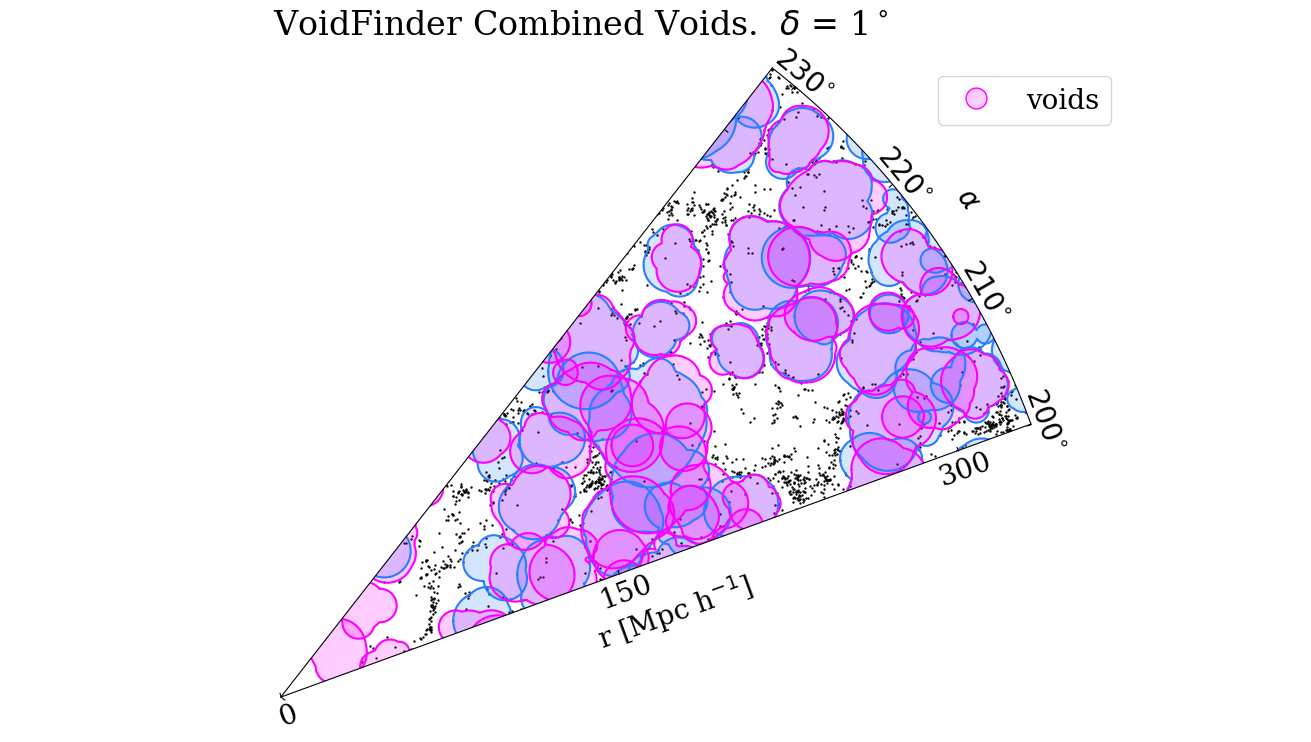

In [26]:
plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph, data_points_DESI = vm_desi.pvf2(1,5,1000,6, 
    200, 232, 0, 0.114, "VoidFinder Combined Voids. ", graph = None, zlimits = True, rot = 180, 
    colors = ['#2a7fff','#2a7fff','#2a7fff'],gal_colors = ['black','black'],
                include_gals=True,include_voids=True,alpha=0.2, border_alpha = 1,
                mag_limit=-20, galaxy_point_size=.5,
    horiz_legend_offset=0.85,plot_sdss=False, return_plot_data=True)

graph, data_points_SDSS = vm_sdss.pvf2(1,5,1000,6, 
    200, 232, 0, 0.114, "VoidFinder Combined Voids. ", graph = graph, zlimits = True, rot = 180,
    colors = ['#ff00ff','#ff00ff','#ff00ff'],gal_colors = [to_rgba('orange',.5),to_rgba('green',.5)],
                include_gals=False,include_voids=True,alpha=0.2, border_alpha = 1,
    horiz_legend_offset=0.85,plot_sdss=False, return_plot_data=True)

plt.savefig("void_finder.png", bbox_inches = "tight", dpi=400)


In [27]:
#save DMP output

dmp_ra=[]
dmp_r=[]
dmp_void = []
for i, void in enumerate(data_points_DESI[:-2]):
    dmp_ra.extend(void[0])
    dmp_r.extend(void[1])
    dmp_void.extend(i * np.ones_like(void[1]).astype(int))
    
dmp_gal_w_ra = data_points_DESI[-2][0]
dmp_gal_w_r = data_points_DESI[-2][1]
dmp_gal_v_ra = data_points_DESI[-1][0]
dmp_gal_v_r = data_points_DESI[-1][1]

dmp_void_info = Table([dmp_ra, dmp_r, dmp_void], names=['RA','R','GROUP'])
dmp_gal_w_info = Table([dmp_gal_w_ra, dmp_gal_w_r], names=['RA','R'])
dmp_gal_v_info = Table([dmp_gal_v_ra, dmp_gal_v_r], names=['RA','R'])


dmp_path = '/global/cfs/cdirs/desi/users/hrincon/DESIVAST/DMP/DESIVAST_figures.fits'
dmp_file = open_fits_file(dmp_path)
hdu = fits.BinTableHDU(dmp_void_info)
hdu.name = 'FIG6_D_V'
dmp_file.append(hdu)
hdu = fits.BinTableHDU(dmp_gal_w_info)
hdu.name = 'FIG6_D_W'
dmp_file.append(hdu)
hdu = fits.BinTableHDU(dmp_gal_v_info)
hdu.name = 'FIG6_D_F'
dmp_file.append(hdu)
#dmp_file.writeto(dmp_path, overwrite=True)

dmp_ra=[]
dmp_r=[]
dmp_void = []
for i, void in enumerate(data_points_SDSS[:-2]):
    dmp_ra.extend(void[0])
    dmp_r.extend(void[1])
    dmp_void.extend(i * np.ones_like(void[1]).astype(int))
    

dmp_void_info = Table([dmp_ra, dmp_r, dmp_void], names=['RA','R','GROUP'])

hdu = fits.BinTableHDU(dmp_void_info)
hdu.name = 'FIG6_S_V'
dmp_file.append(hdu)
dmp_file.writeto(dmp_path, overwrite=True)


In [28]:
vmv_desi = vsp.VoidMapV2(v2v_desi.triangle, v2v_desi.galzone, v2v_desi.zonevoid,
                   v2v_desi.voids, v2v_desi.galaxies)
vmv_sdss = vsp.VoidMapV2(v2v_sdss.triangle, v2v_sdss.galzone, v2v_sdss.zonevoid,
                   v2v_sdss.voids, v2v_sdss.galaxies)

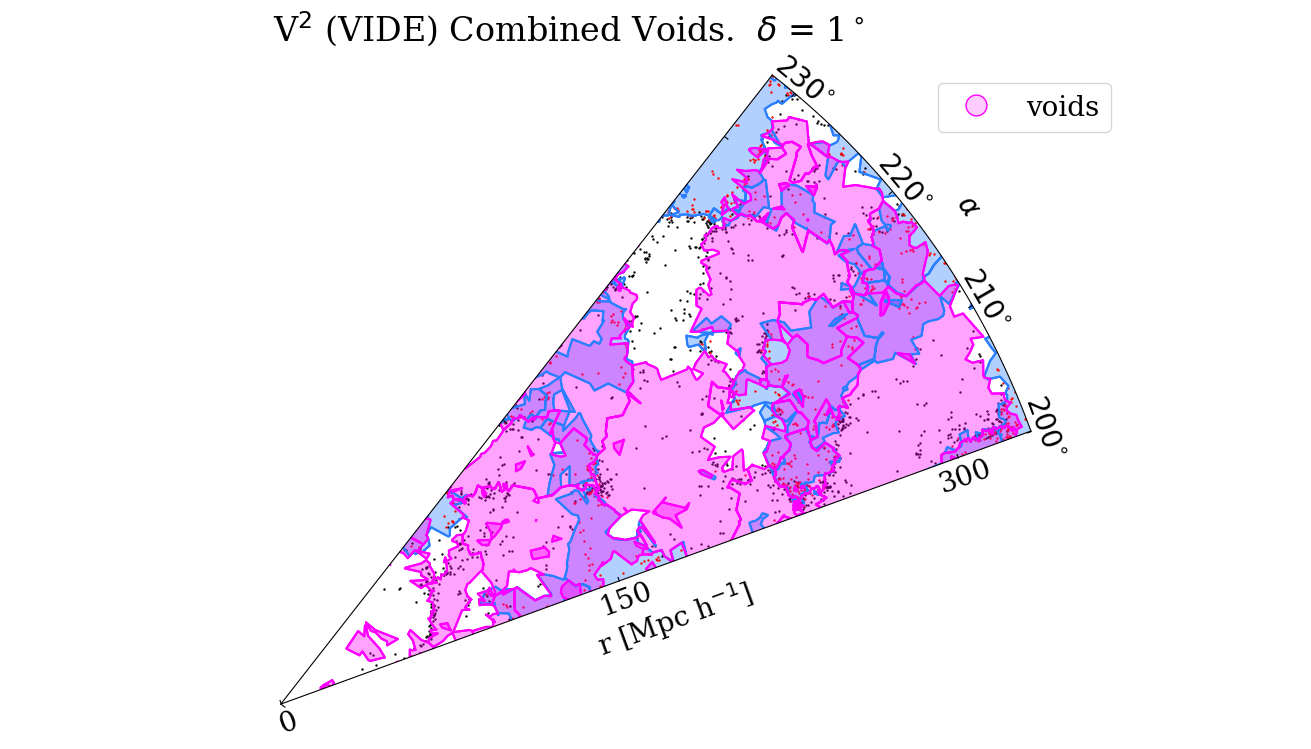

In [29]:
plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph = vmv_desi.pzbv(1,5,
    200, 232, 0, 0.114, "V$^2$ (VIDE) Combined Voids. ", graph = None, zlimits = True, rot = 180, 
    colors = ['#2a7fff','#2a7fff','#2a7fff'],#gal_colors = ['black','black'],
                include_gals=True,#include_voids=True,
                alpha=0.2, #border_alpha = 1,
            mag_limit=-20, galaxy_point_size=.5,
    horiz_legend_offset=0.85,plot_sdss=False)

graph = vmv_sdss.pzbv(1,5,
    200, 232, 0, 0.114, "V$^2$ (VIDE) Combined Voids. ", graph = graph, zlimits = True, rot = 180,
    colors = ['#ff00ff','#ff00ff','#ff00ff'],#gal_colors = [to_rgba('orange',.5),to_rgba('green',.5)],
                include_gals=False,#include_voids=True,
                      alpha=0.2, #border_alpha = 1,
    horiz_legend_offset=0.85,plot_sdss=False)

plt.savefig("v2_vide.png", bbox_inches = "tight")


In [30]:
vmr_desi = vsp.VoidMapV2(v2r_desi.triangle, v2r_desi.galzone, v2r_desi.zonevoid,
                   v2r_desi.voids, v2r_desi.galaxies)
vmr_sdss = vsp.VoidMapV2(v2r_sdss.triangle, v2r_sdss.galzone, v2r_sdss.zonevoid,
                   v2r_sdss.voids, v2r_sdss.galaxies)

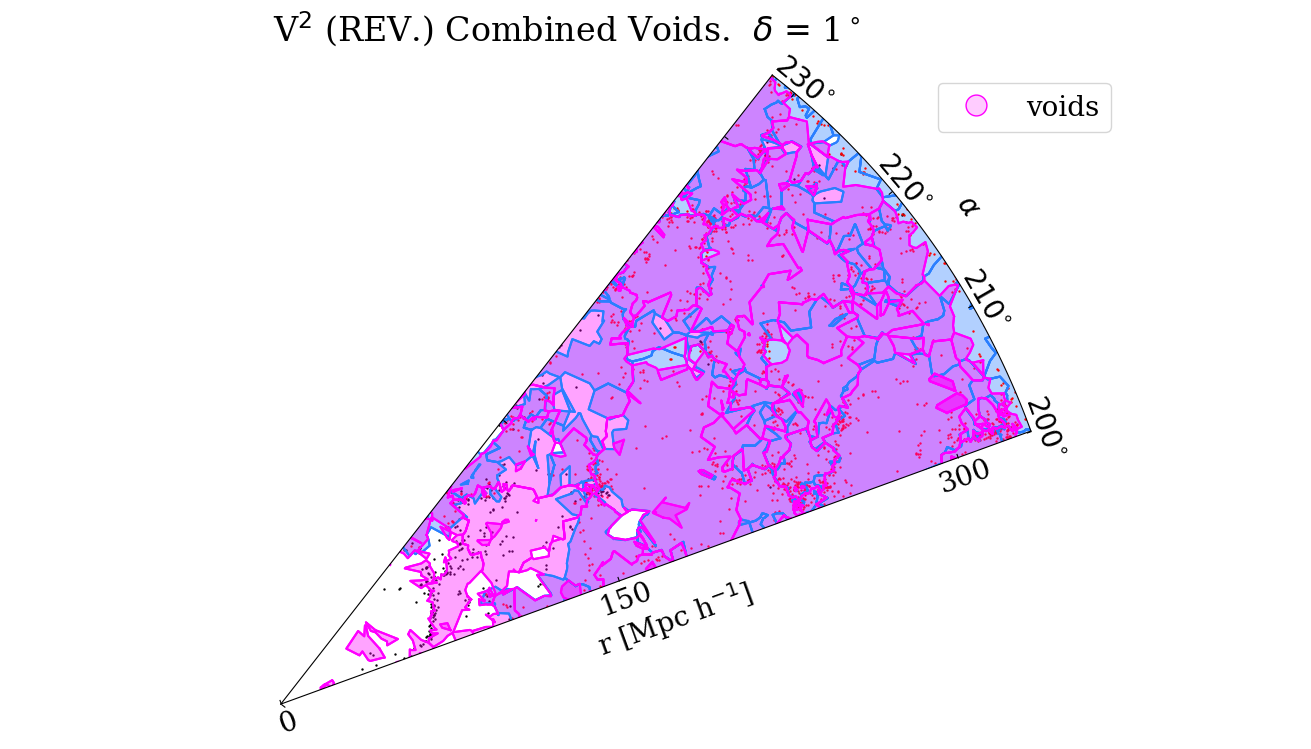

In [31]:
plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph = vmr_desi.pzbv(1,5,
    200, 232, 0, 0.114, "V$^2$ (REV.) Combined Voids. ", graph = None, zlimits = True, rot = 180, 
    colors = ['#2a7fff','#2a7fff','#2a7fff'],#gal_colors = ['black','black'],
                include_gals=True,#include_voids=True,
                alpha=0.2, #border_alpha = 1,
                mag_limit=-20, galaxy_point_size=.5,
    horiz_legend_offset=0.85,plot_sdss=False)

graph = vmr_sdss.pzbv(1,5,
    200, 232, 0, 0.114, "V$^2$ (REV.) Combined Voids. ", graph = graph, zlimits = True, rot = 180,
    colors = ['#ff00ff','#ff00ff','#ff00ff'],#gal_colors = [to_rgba('orange',.5),to_rgba('green',.5)],
                include_gals=False,#include_voids=True,
                      alpha=0.2, #border_alpha = 1,
    horiz_legend_offset=0.85,plot_sdss=False)

plt.savefig("v2_rev.png", bbox_inches = "tight")
